# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from numpy import mean
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from lightgbm import LGBMClassifier
from collections import Counter
import joblib

In [2]:
# chargement des données rééquilibrées
root = r"C:\Users\vassalr\OneDrive - STMicroelectronics\Documents\Robin\DataScience\Projets\7_ImplémentezUnModèleDeScoring\afterBalancingData"
name = "X_balanced.pickle"
X_train = pd.read_pickle(os.path.join(root, name))
name = "y_balanced.pickle"
y_train = pd.read_pickle(os.path.join(root, name))
name = "X_test.pickle"
X_test = pd.read_pickle(os.path.join(root, name))
name = "y_test.pickle"
y_test = pd.read_pickle(os.path.join(root, name))

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(201163, 122)
(201163,)
(76877, 122)
(76877,)


In [4]:
X_train = X_train.sample(frac=0.45, replace=False, random_state=5)
y_train = y_train.sample(frac=0.45, replace=False, random_state=5)

# XGBoost

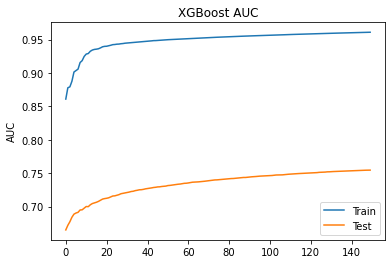

In [5]:
from xgboost import XGBClassifier

modelXGB = XGBClassifier(verbosity=0)
params_go = {'colsample_bytree':1, 'eta':0.05, "eval_metric":"auc", "gamma":0, "max_depth":5, 'min_child_weight':1, 
             "n_estimators":150, "objective":"binary:logistic","silent":1, "subsample":0.75}
modelXGB.set_params(**params_go)
modelXGB.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_metric="auc", verbose=False)
results = modelXGB.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [6]:
# save the model to disk
root = r"C:\Users\vassalr\OneDrive - STMicroelectronics\Documents\Robin\DataScience\Projets\7_ImplémentezUnModèleDeScoring\model"
filename = 'xgbClassifier_go.sav'
joblib.dump(modelXGB, os.path.join(root, filename))

['C:\\Users\\vassalr\\OneDrive - STMicroelectronics\\Documents\\Robin\\DataScience\\Projets\\7_ImplémentezUnModèleDeScoring\\model\\xgbClassifier_go.sav']

# Globale with feature_importances

In [7]:
modelXGB.feature_importances_

array([0.00159706, 0.0104362 , 0.01459042, 0.00773555, 0.02555056,
       0.02728152, 0.00313098, 0.0006788 , 0.0051347 , 0.00324318,
       0.00150396, 0.01885793, 0.00176345, 0.01090711, 0.01251799,
       0.00310266, 0.00975553, 0.00229117, 0.00256141, 0.01508702,
       0.00356421, 0.00153582, 0.00222908, 0.00202373, 0.00227573,
       0.00367946, 0.00226541, 0.0434016 , 0.00319437, 0.00212356,
       0.00564735, 0.00164793, 0.00392196, 0.00145979, 0.00308582,
       0.00608784, 0.00210723, 0.00282652, 0.00140213, 0.04697358,
       0.07167301, 0.01288998, 0.00201807, 0.0018299 , 0.00413714,
       0.00209641, 0.        , 0.00109662, 0.00564857, 0.00159896,
       0.00513583, 0.00271875, 0.00502865, 0.00070909, 0.004993  ,
       0.00204936, 0.00540051, 0.00068192, 0.00116673, 0.00480514,
       0.        , 0.03530908, 0.0860508 , 0.07200053, 0.02790353,
       0.00130688, 0.00172324, 0.00286794, 0.01023267, 0.00145256,
       0.00084381, 0.00110424, 0.00200539, 0.01021454, 0.00096

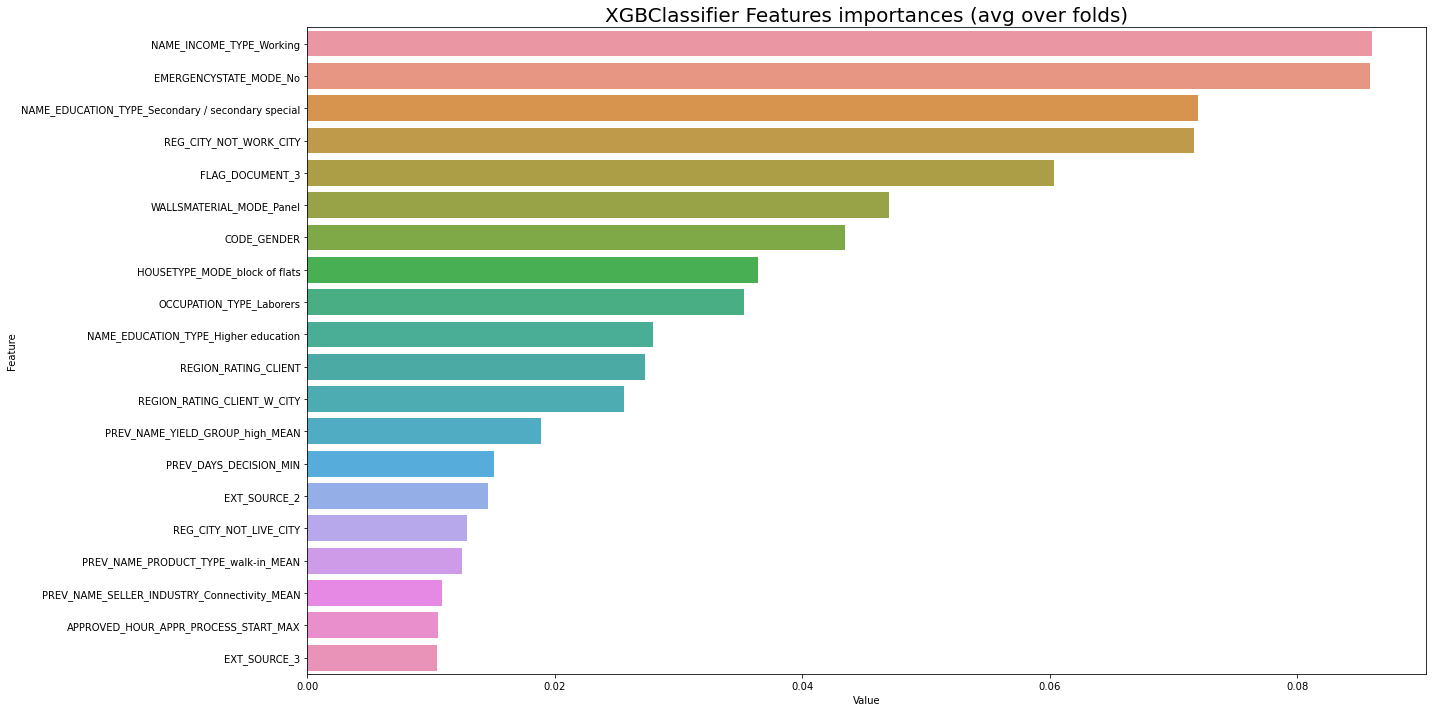

In [8]:
# a normaliser ou pas 
feature_imp = pd.DataFrame(sorted(zip(modelXGB.feature_importances_, X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('XGBClassifier Features importances (avg over folds)', fontsize=20)
plt.tight_layout()
plt.show()

In [9]:
list(feature_imp.sort_values(by="Value", ascending=False)[:20]["Feature"])

['NAME_INCOME_TYPE_Working',
 'EMERGENCYSTATE_MODE_No',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_3',
 'WALLSMATERIAL_MODE_Panel',
 'CODE_GENDER',
 'HOUSETYPE_MODE_block of flats',
 'OCCUPATION_TYPE_Laborers',
 'NAME_EDUCATION_TYPE_Higher education',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'PREV_NAME_YIELD_GROUP_high_MEAN',
 'PREV_DAYS_DECISION_MIN',
 'EXT_SOURCE_2',
 'REG_CITY_NOT_LIVE_CITY',
 'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN',
 'APPROVED_HOUR_APPR_PROCESS_START_MAX',
 'EXT_SOURCE_3']

# Locale with lime_tabular

In [10]:
modelXGB

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.05, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, silent=1, subsample=0.75, tree_method='exact',
              validate_parameters=1, ...)

In [11]:
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(X_test.values, mode="classification", feature_names= X_test.columns,
                                             class_names=["solvable", "non_solvable"], discretize_continuous=True)
explainer

In [12]:
print(modelXGB.predict_proba(X_test.iloc[[0]]))
print(X_test.shape)

[[0.7037374  0.29626265]]
(76877, 122)


In [13]:
# Convert X_test float64 into float 32
X_test[X_test.select_dtypes(np.float64).columns] = X_test.select_dtypes(np.float64).astype(np.float32)

In [14]:
file = r"C:\Users\vassalr\OneDrive - STMicroelectronics\Documents\Robin\DataScience\Projets\7_ImplémentezUnModèleDeScoring\X_test_32.pickle"
X_test.to_pickle(file)

In [15]:
len(X_test)

76877

In [16]:
interpretability_list = []
count = 0 
for customer in range(len(X_test)):
    explainer_customer = explainer.explain_instance(X_test.values[customer], modelXGB.predict_proba)
    interpretability_list.append(explainer_customer)
    count+=1
    if count % 100 == 0 :
        print(count)
joblib.dump(interpretability_list, "interpretability_list.joblib")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400


KeyboardInterrupt: 

In [19]:
len(interpretability_list)

3488

In [20]:
joblib.dump(interpretability_list, "interpretability_list3488.joblib")

['interpretability_list3488.joblib']

In [ ]:
interpretability_list[2].show_in_notebook(show_table=True)

In [ ]:
interpretability_list[2].as_pyplot_figure()